# Needle Insertion Markov Decision Process

In [1]:
using POMDPs
using Distributions
using POMDPToolbox
using PyPlot

## States
The data container below represents the state of the agent in the grid world.

In [2]:
type NeedleState 
    x::Int64 # x position
    y::Int64 # y position
    psi::Int64 # orientation
    bumped::Bool # did we bump the wall?
    done::Bool # are we in a terminal state?
end

Below are some convenience functions for working with the NeedleState. 

In [3]:
# initial state constructor
NeedleState(x::Int64, y::Int64, psi::Int64) = NeedleState(x,y,psi,false,false)
# checks if the position of two states are the same
posequal(s1::NeedleState, s2::NeedleState) = s1.x == s2.x && s1.y == s2.y && s1.psi == s2.psi
# copies state s2 to s1
function Base.copy!(s1::NeedleState, s2::NeedleState) 
    s1.x = s2.x
    s1.y = s2.y
    s1.psi = s2.psi
    s1.bumped = s2.bumped
    s1.done = s2.done
    s1
end
# if you want to use Monte Carlo Tree Search, you will need to define the functions below
Base.hash(s::NeedleState, h::UInt64 = zero(UInt64)) = hash(s.x, hash(s.y, hash(s.psi, hash(s.bumped, hash(s.done, h)))))
Base.isequal(s1::NeedleState,s2::NeedleState) = s1.x == s2.x && s1.y == s2.y && s1.psi == s2.psi && s1.bumped == s2.bumped && s1.done == s2.done;

## Actions
Since our action is simply the direction the agent chooses to go (i.e. cw, ccw), we can use a Symbol to represent it. Symbols are special types in Julia that allow for nice represntation of complex data. However, in our case a string could serve the same purpose as the symbol or even and integer, so feel free to use what you're most comfortable with. Note that in this case, we will not define a type for our action, instead we represent it directly with a symbol.

## MDP
The Needle data container is defined below. It holds all the information we need to define the MDP tuple $$(\mathcal{S}, \mathcal{A}, T, R).$$

In [4]:
# the needle mdp type
type Needle <: MDP{NeedleState, Symbol} # Note that our MDP is parametarized by the state and the action
    size_x::Int64 # x size of the grid
    size_y::Int64 # y size of the grid
    size_psi::Int64 # number of orientation bins
    reward_states::Vector{NeedleState} # target/obstacle states
    reward_values::Vector{Float64} # reward values for those states
#     bounds_penalty::Float64 # penalty for bumping the wall
    tprob::Array{Float64} # probability of transitioning to the desired state
    discount_factor::Float64 # disocunt factor
    
end

Before moving on, I want to create a constructor for Needle for convenience. Currently, if I want to create an instance of Needle, I have to pass in all of fields inside the Needle container (size_x, size_y, etc). The function below will return a Needle type with all the fields filled with some default values.

In [5]:
# we use key worded arguments so we can change any of the values we pass in 
function Needle(;sx::Int64 = 10, # size_x
                sy::Int64 = 10, # size_y
                spsi::Int64 = 8, # size_psi
                rs::Vector{NeedleState} = [[NeedleState(8,4,psi) for psi = 1:spsi]; # target states
                                            [NeedleState(4,6,psi) for psi = 1:spsi]; # obstacle states
                                            [NeedleState(1,y,psi) for y = 1:sy, psi = 3:7][:]; # boundary states
                                            [NeedleState(sx,y,psi) for y = 1:sy, psi = [1:3;7:spsi]][:];
                                            [NeedleState(x,1,psi) for x = 2:sx-1, psi = [5:spsi;1]][:];
                                            [NeedleState(x,sy,psi) for x = 2:sx-1, psi = 1:5][:]],
                rv::Vector{Float64} = [fill(100.0,spsi); fill(-20.0,spsi); fill(-5,(2*sx+2*sy-4)*5)],
                tp::Array{Float64} = [0.05, 0.9, 0.05, 0.0], # tprob
                discount_factor::Float64 = 0.9)
    return Needle(sx, sy, spsi, rs, rv, tp, discount_factor)
end

# we can now create a NeedleState mdp instance like this:
mdp = Needle()
mdp.reward_states # mdp contains all the defualt values from the constructor

196-element Array{NeedleState,1}:
 NeedleState(8,4,1,false,false) 
 NeedleState(8,4,2,false,false) 
 NeedleState(8,4,3,false,false) 
 NeedleState(8,4,4,false,false) 
 NeedleState(8,4,5,false,false) 
 NeedleState(8,4,6,false,false) 
 NeedleState(8,4,7,false,false) 
 NeedleState(8,4,8,false,false) 
 NeedleState(4,6,1,false,false) 
 NeedleState(4,6,2,false,false) 
 NeedleState(4,6,3,false,false) 
 NeedleState(4,6,4,false,false) 
 NeedleState(4,6,5,false,false) 
 ⋮                              
 NeedleState(6,10,4,false,false)
 NeedleState(7,10,4,false,false)
 NeedleState(8,10,4,false,false)
 NeedleState(9,10,4,false,false)
 NeedleState(2,10,5,false,false)
 NeedleState(3,10,5,false,false)
 NeedleState(4,10,5,false,false)
 NeedleState(5,10,5,false,false)
 NeedleState(6,10,5,false,false)
 NeedleState(7,10,5,false,false)
 NeedleState(8,10,5,false,false)
 NeedleState(9,10,5,false,false)

## Spaces

### State Space ($ \mathcal{S}$)
The state space in an MDP represents all the states in the problem. There are two primary functionalities that we want our spaces to support. We want to be able to iterate over the state space (for Value Iteration for example), and sometimes we want to be able to sample form the state space (used in some POMDP solvers). In this notebook, we will only look at iterable state spaces. 

In [6]:
type StateSpace <: AbstractSpace
    states::Vector{NeedleState}
end

Since we can iterate over elements of an array, and our problem is small, we can store all of our states in an array. If your problem is very large (tens of millions of states), it might be worthwhile to create an iterator over your state space. See [this](http://stackoverflow.com/questions/25028539/how-to-implement-an-iterator-in-julia) post on stackoverflow on making simple iterators. 

In [7]:
function POMDPs.states(mdp::Needle)
    s = NeedleState[] # initialize an array of NeedleStates
    # loop over all our states, remeber there are two binary variables: done (d) and bumped(b)
    for d = 0:1, b = 0:1, y = 1:mdp.size_y, x = 1:mdp.size_x, psi = 1:mdp.size_psi
        push!(s, NeedleState(x,y,psi,b,d))
    end
    return StateSpace(s)
end;

To finish up we need to define a function that returns the iterator over the state space. Remeber ```states(...)``` returns the state space type, and our iterator is hidden inside of it.

In [8]:
function POMDPs.iterator(space::StateSpace)
    return space.states 
end;

We want to be able to uniformly sample for our state space. A sampling function for doing this is fairly simple to implement if you already have an array of all your states.

In [9]:
function POMDPs.rand(rng::AbstractRNG, space::StateSpace, s::NeedleState)
    sp = space.states[rand(rng, 1:end)]
    copy!(s, sp)
    s
end;

### Action Space ($\mathcal{A}$)

The action space is the set of all actions availiable to the agent. In the grid world problem the action space consists of up, down, left, and right. Let's define the type for our action space.

In [10]:
type ActionSpace <: AbstractSpace
    actions::Vector{Symbol}
end

Let's now write a function called actions that returns our action space.

In [11]:
function POMDPs.actions(mdp::Needle)
    acts = [:cw, :ccw]
    return ActionSpace(acts)
end;
POMDPs.actions(mdp::Needle, s::NeedleState, as::ActionSpace=actions(mdp)) = as;

In [12]:
function POMDPs.iterator(space::ActionSpace)
    return space.actions 
end;

In [13]:
function POMDPs.rand(rng::AbstractRNG, space::ActionSpace, a::Symbol)
    return space.actions[rand(rng, 1:end)]
end;
function POMDPs.rand(rng::AbstractRNG, space::ActionSpace)
    a = NeedleAction(:cw)
    return rand(rng, space, a)
end;

To finish up, we add a couple of initializer functions for out state and action.

In [14]:
POMDPs.create_state(mdp::Needle) = NeedleState(1,1,1)
POMDPs.create_action(mdp::Needle) = :cw;

## Distributions

Since MDPs are probabilistic models, we have to deal with probability distributions. In this section, we outline how to define probability distriubtions, and what tools are availiable to help you with the task.

### Transition Distribution 

If you are familiar with MDPs, you know that the transition function $T(s' \mid s, a)$ captures the dynamics of the system. Specifically, $T(s' \mid s, a)$ is a real value that defines the probabiltiy of transitioning to state $s'$ given that you took action $a$ in state $s$. The transition distirubtion $T(\cdot \mid s, a)$ is a slightly different construct. This is the actual distribution over the states that our agent can reach given that its in state $s$ and took action $a$. In other words this is the distribution over $s'$. 

There are many ways to implement transition distributions for your problem. Your choice of distribution as well as how you implement it will heavily depend on your problem. [Distributions.jl](https://github.com/JuliaStats/Distributions.jl) provides support for many common univariate and multivarite distributions. Below is how we implement the one for grid world. 

In [15]:
type NeedleDistribution <: AbstractDistribution
    neighbors::Array{NeedleState} # the states s' in the distribution
    probs::Array{Float64} # the probability corresponding to each state s'
    cat::Categorical # this comes from Distributions.jl and is used for sampling
end

To reduce memory allocation, the POMDPs.jl interface defines some initalization functions that return initial types to be filled lated. This function returns the distribution type filled with some values. We don't care what the distribution container has in it, because it will be modified at each call to the transition function.

In [16]:
function POMDPs.create_transition_distribution(mdp::Needle)
    # can have at most five neighbors in grid world
    neighbors =  [NeedleState(i,i,1) for i = 1:5]
    probabilities = zeros(5) + 1.0/5.0
    cat = Categorical(5)
    return NeedleDistribution(neighbors, probabilities, cat)
end;

The next function we want is ```domain(...)```. For discrete state distributions, domain returns an iterator over the states in that distributions (this is just the neighbors array in our distriubtion type). The function takes on the following form:

In [17]:
function POMDPs.iterator(d::NeedleDistribution)
    return d.neighbors
end;

Let's implement the probability density function (really this is a probability mass function since the distriubtion is discrete, but we overload the pdf function name to serve as both). Below is a fairly inneficient impelemntation of pdf. For the discrete distribution in our problem, the pdf function returns the probability of drawing the state s from the distribution d. 

In [18]:
function POMDPs.pdf(d::NeedleDistribution, s::NeedleState)
    for (i, sp) in enumerate(d.neighbors)
        if s == sp
            return d.probs[i]
        end
    end   
    return 0.0
end;

Finally, we want to implement a smapling function that can draw samples from our distribution. Once again, there are many ways to do this, but we recommend using Distributions.jl. We use POMDPDistributions which mimicks a lot of the behavior of Distributions.jl. 

In [19]:
function POMDPs.rand(rng::AbstractRNG, d::NeedleDistribution, s::NeedleState)
    d.cat = Categorical(d.probs) # init the categorical distribution
    ns = d.neighbors[rand(d.cat)] # sample a neighbor state according to the distribution c
    copy!(s, ns)
    return s # return the pointer to s
end;

To recap, there are two functionalities that we require your distirbutions to support. We want to be able to sample from them using the ```rand!(...)``` function, and we want to obtain the probability density using the ```pdf(...)``` function.

## Transition Model (T)

In this section we will define the system dynamics of the gird world MDP. In POMDPs.jl, we work with transition distirbution functions $T(s' \mid s, a)$, so we want to write a function that can generate the transition distributions over $s'$ for us given an $(s, a)$ pair. 

In the transition function we want to fill the neighbors in our distribution d with the reachable states from the state, action pair. We want to fill the probs in our distirbution d with the probabilities of reaching that neighbor. 

In [20]:
# transition helpers
function inbounds(mdp::Needle,x::Int64,y::Int64,psi::Int64)
    if 1 <= x <= mdp.size_x && 1 <= y <= mdp.size_y && 1 <= psi <= mdp.size_psi
        return true
    else
        return false
    end
end

function inbounds(mdp::Needle,state::NeedleState)
    x = state.x
    y = state.y
    psi = state.psi
    return inbounds(mdp, x, y, psi)
end

###########################################################

function atbounds(mdp::Needle,x::Int64,y::Int64,psi::Int64)
    # at bounds if: at wall, facing outward or at corner
    if (x == 1 || x == mdp.size_x) && (y == 1 || y == mdp.size_y) # at corner
        return true
        elseif (x == 1 && 3 <= psi <= 7) || (x == mdp.size_x && (7 <= psi || psi <= 3) ) ||
        (y == 1 && (5 <= psi || psi <= 1) ) || (y == mdp.size_y && 1 <= psi <= 5) # at wall, facing outward
        return true
    else
        return false
    end
end

function atbounds(mdp::Needle,state::NeedleState)
    x = state.x
    y = state.y
    psi = state.psi
    return atbounds(mdp, x, y, psi)
end

###########################################################

function fill_probability!(p::Vector{Float64}, val::Float64, index::Int64)
    for i = 1:length(p)
        if i == index
            p[i] = val
        else
            p[i] = 0.0
        end
    end
end;


In [21]:
function POMDPs.transition(mdp::Needle,
                            state::NeedleState,
                            action::Symbol,
                            d::NeedleDistribution=create_transition_distribution(mdp))
    tp = mdp.tprob
    
    a = action
    x = state.x
    y = state.y
    psi = state.psi
    
    neighbors = d.neighbors
    probability = d.probs
    
    # let's handle the done case first
    if state.done
        # can only transition to the same done state
        fill!(probability, 0.0)
        probability[1] = 1.0
        copy!(neighbors[1], state)
        # when we sample d, we will only get the state in neighbors[1] - our done state
        return d
    end
    
    fill!(probability, 0.0)

    if a == :ccw
        if psi == 1
            neighbors[1].x = x+1; neighbors[1].y = y;   neighbors[1].psi = psi; 
            neighbors[2].x = x+1; neighbors[2].y = y;   neighbors[2].psi = psi+1;
            neighbors[3].x = x+1; neighbors[3].y = y+1; neighbors[3].psi = psi+1;
            neighbors[4].x = x+1; neighbors[4].y = y+1; neighbors[4].psi = psi+2;
        elseif psi == 2
            neighbors[1].x = x+1; neighbors[1].y = y+1; neighbors[1].psi = psi; 
            neighbors[2].x = x+1; neighbors[2].y = y+1; neighbors[2].psi = psi+1;
            neighbors[3].x = x;   neighbors[3].y = y+1; neighbors[3].psi = psi+1;
            neighbors[4].x = x;   neighbors[4].y = y+1; neighbors[4].psi = psi+2;
        elseif psi == 3
            neighbors[1].x = x;   neighbors[1].y = y+1; neighbors[1].psi = psi; 
            neighbors[2].x = x;   neighbors[2].y = y+1; neighbors[2].psi = psi+1;
            neighbors[3].x = x-1; neighbors[3].y = y+1; neighbors[3].psi = psi+1;
            neighbors[4].x = x-1; neighbors[4].y = y+1; neighbors[4].psi = psi+2;
        elseif psi == 4
            neighbors[1].x = x-1; neighbors[1].y = y+1; neighbors[1].psi = psi; 
            neighbors[2].x = x-1; neighbors[2].y = y+1; neighbors[2].psi = psi+1;
            neighbors[3].x = x-1; neighbors[3].y = y;   neighbors[3].psi = psi+1;
            neighbors[4].x = x-1; neighbors[4].y = y;   neighbors[4].psi = psi+2;
        elseif psi == 5
            neighbors[1].x = x-1; neighbors[1].y = y;   neighbors[1].psi = psi; 
            neighbors[2].x = x-1; neighbors[2].y = y;   neighbors[2].psi = psi+1;
            neighbors[3].x = x-1; neighbors[3].y = y-1; neighbors[3].psi = psi+1;
            neighbors[4].x = x-1; neighbors[4].y = y-1; neighbors[4].psi = psi+2;
        elseif psi == 6
            neighbors[1].x = x-1; neighbors[1].y = y-1; neighbors[1].psi = psi; 
            neighbors[2].x = x-1; neighbors[2].y = y-1; neighbors[2].psi = psi+1;
            neighbors[3].x = x;   neighbors[3].y = y-1; neighbors[3].psi = psi+1;
            neighbors[4].x = x;   neighbors[4].y = y-1; neighbors[4].psi = psi+2;
        elseif psi == 7
            neighbors[1].x = x;   neighbors[1].y = y-1; neighbors[1].psi = psi; 
            neighbors[2].x = x;   neighbors[2].y = y-1; neighbors[2].psi = psi+1;
            neighbors[3].x = x+1; neighbors[3].y = y-1; neighbors[3].psi = psi+1;
            neighbors[4].x = x+1; neighbors[4].y = y-1; neighbors[4].psi = psi+2;
        elseif psi == 8
            neighbors[1].x = x+1; neighbors[1].y = y-1; neighbors[1].psi = psi; 
            neighbors[2].x = x+1; neighbors[2].y = y-1; neighbors[2].psi = psi+1;
            neighbors[3].x = x+1; neighbors[3].y = y;   neighbors[3].psi = psi+1;
            neighbors[4].x = x+1; neighbors[4].y = y;   neighbors[4].psi = psi+2;
        end
    elseif a == :cw
        if psi == 1
            neighbors[1].x = x+1; neighbors[1].y = y;   neighbors[1].psi = psi; 
            neighbors[2].x = x+1; neighbors[2].y = y;   neighbors[2].psi = psi+7;
            neighbors[3].x = x+1; neighbors[3].y = y-1; neighbors[3].psi = psi+7;
            neighbors[4].x = x+1; neighbors[4].y = y-1; neighbors[4].psi = psi+6;
        elseif psi == 2
            neighbors[1].x = x+1; neighbors[1].y = y+1; neighbors[1].psi = psi; 
            neighbors[2].x = x+1; neighbors[2].y = y+1; neighbors[2].psi = psi+7;
            neighbors[3].x = x+1; neighbors[3].y = y;   neighbors[3].psi = psi+7;
            neighbors[4].x = x+1; neighbors[4].y = y;   neighbors[4].psi = psi+6;
        elseif psi == 3
            neighbors[1].x = x;   neighbors[1].y = y+1; neighbors[1].psi = psi; 
            neighbors[2].x = x;   neighbors[2].y = y+1; neighbors[2].psi = psi+7;
            neighbors[3].x = x+1; neighbors[3].y = y+1; neighbors[3].psi = psi+7;
            neighbors[4].x = x+1; neighbors[4].y = y+1; neighbors[4].psi = psi+6;
        elseif psi == 4
            neighbors[1].x = x-1; neighbors[1].y = y+1; neighbors[1].psi = psi; 
            neighbors[2].x = x-1; neighbors[2].y = y+1; neighbors[2].psi = psi+7;
            neighbors[3].x = x;   neighbors[3].y = y+1; neighbors[3].psi = psi+7;
            neighbors[4].x = x;   neighbors[4].y = y+1; neighbors[4].psi = psi+6;
        elseif psi == 5
            neighbors[1].x = x-1; neighbors[1].y = y;   neighbors[1].psi = psi; 
            neighbors[2].x = x-1; neighbors[2].y = y;   neighbors[2].psi = psi+7;
            neighbors[3].x = x-1; neighbors[3].y = y+1; neighbors[3].psi = psi+7;
            neighbors[4].x = x-1; neighbors[4].y = y+1; neighbors[4].psi = psi+6;
        elseif psi == 6
            neighbors[1].x = x-1; neighbors[1].y = y-1; neighbors[1].psi = psi; 
            neighbors[2].x = x-1; neighbors[2].y = y-1; neighbors[2].psi = psi+7;
            neighbors[3].x = x-1; neighbors[3].y = y;   neighbors[3].psi = psi+7;
            neighbors[4].x = x-1; neighbors[4].y = y;   neighbors[4].psi = psi+6;
        elseif psi == 7
            neighbors[1].x = x;   neighbors[1].y = y-1; neighbors[1].psi = psi; 
            neighbors[2].x = x;   neighbors[2].y = y-1; neighbors[2].psi = psi+7;
            neighbors[3].x = x-1; neighbors[3].y = y-1; neighbors[3].psi = psi+7;
            neighbors[4].x = x-1; neighbors[4].y = y-1; neighbors[4].psi = psi+6;
        elseif psi == 8
            neighbors[1].x = x+1; neighbors[1].y = y-1; neighbors[1].psi = psi; 
            neighbors[2].x = x+1; neighbors[2].y = y-1; neighbors[2].psi = psi+7;
            neighbors[3].x = x;   neighbors[3].y = y-1; neighbors[3].psi = psi+7;
            neighbors[4].x = x;   neighbors[4].y = y-1; neighbors[4].psi = psi+6;
        end
    end
    # make sure psi is between 1 and 8
    for i = 1:4
        neighbors[i].psi = mod(neighbors[i].psi,8)
        if neighbors[i].psi == 0
            neighbors[i].psi = 8;
        end
    end
    neighbors[5].x = x; neighbors[5].y = y; neighbors[5].psi = psi;
    
    # initialize bumped and done states 
    for i = 1:5 neighbors[i].bumped = false end
    for i = 1:5 neighbors[i].done = false end
    reward_states = mdp.reward_states
    
    # detection of done states
    n = length(reward_states)
    for i = 1:n
        # terminate at target/obstacle
        if posequal(state, reward_states[i])
            fill_probability!(probability, 1.0, 5)
            neighbors[5].done = true
            return d
        end
        # terminate at boundary
        if atbounds(mdp, state)
            fill_probability!(probability, 1.0, 5)
            neighbors[5].done = true
            neighbors[5].bumped = true
            return d
        end
    end
    
    if !inbounds(mdp, neighbors[1]) || !inbounds(mdp, neighbors[2]) ||
        !inbounds(mdp, neighbors[3]) || !inbounds(mdp, neighbors[4]) # at least one of the neighbors is outside bounds
        fill_probability!(probability, 1.0, 5) # stuck in current state when terminated
        neighbors[5].bumped = true     
    else # none of the neighbors is outside bounds
        probability[1:4] = tp
    end
    
    return d
end;

## Reward Model (R)
The reward model $R(s,a,s')$ is a function that returns the reward of being in state $s$, taking an action $a$ from that state, and ending up in state $s'$. In our problem, we are rewarded for reaching a terimanl reward state (this could be positive or negative), and we are penalized for bumping into a wall.

In [22]:
function POMDPs.reward(mdp::Needle, state::NeedleState, action::Symbol, statep::NeedleState) #deleted action
    if state.done
        return 0.0
    end
    r = 0.0
    reward_states = mdp.reward_states
    reward_values = mdp.reward_values
    n = length(reward_states)
    for i = 1:n
        if posequal(state, reward_states[i]) # reward, obstacle and wall states
            r += reward_values[i]
        end
    end
    r += -1; # penalty for every step taken
#     if state.bumped
#         r += mdp.bounds_penalty
#     end
    
    return r
end;


## Miscellaneous Functions
We are almost done! Just a few simple functions left. First let's implement two functions that return the sizes of our state and action spaces.

In [23]:
POMDPs.n_states(mdp::Needle) = 4*mdp.size_x*mdp.size_y*mdp.size_psi
POMDPs.n_actions(mdp::Needle) = 4
POMDPs.discount(mdp::Needle) = mdp.discount_factor;

The last thing we need is an indexing function. This allows us to index between the discrete utility array and the states in our problem. We will use the ```sub2ind()``` function from Julia base to help us here. 

In [24]:
function POMDPs.state_index(mdp::Needle, state::NeedleState)
    sb = Int(state.bumped + 1)
    sd = Int(state.done + 1)
    return sub2ind((mdp.size_x, mdp.size_y, mdp.size_psi, 2, 2), state.x, state.y, state.psi, sb, sd)
end;

Finally let's define a function that checks if a state is terminal.

In [25]:
function POMDPs.isterminal(mdp::Needle, s::NeedleState)
    s.done ? (return true) : (return false)
end;

## Value Iteration Solver

Each POMDPs.jl solver provides two data types for you to interface with. The first is the Solver type which contains solver parameters. The second is the Policy type. Let's see hwo we can use them to get an optimal action at a given state.

In [42]:
using DiscreteValueIteration

# initialize the problem
mdp = Needle()

# initialize the solver
# max_iterations: maximum number of iterations value iteration runs for (default is 100)
# belres: the value of Bellman residual used in the solver (defualt is 1e-3)
solver = ValueIterationSolver(max_iterations=100, belres=1e-3)

# initialize the policy by passing in your problem
policy_vi = ValueIterationPolicy(mdp)

# solve for an optimal policy
# if verbose=false, the text output will be supressed (false by default)
solve(solver, mdp, policy_vi, verbose=true);

Iteration : 1, residual: 99.0, iteration run-time: 0.31350729, total run-time: 0.31350729
Iteration : 2, residual: 71.29575000000001, iteration run-time: 0.310174328, total run-time: 0.623681618
Iteration : 3, residual: 57.70896637500002, iteration run-time: 0.307704855, total run-time: 0.931386473
Iteration : 4, residual: 38.759395906801544, iteration run-time: 0.3126935, total run-time: 1.244079973
Iteration : 5, residual: 31.986784885797615, iteration run-time: 0.310078775, total run-time: 1.554158748
Iteration : 6, residual: 25.62353365735233, iteration run-time: 0.314514578, total run-time: 1.8686733260000001
Iteration : 7, residual: 18.921858511010647, iteration run-time: 0.311437613, total run-time: 2.180110939
Iteration : 8, residual: 12.82880737061843, iteration run-time: 0.312944334, total run-time: 2.493055273
Iteration : 9, residual: 5.3782266470799165, iteration run-time: 0.310114799, total run-time: 2.803170072
Iteration : 10, residual: 1.9403980293356227, iteration run-t

## Monte-Carlo Tree Search Solver
Monte-Carlo Tree Search (MCTS) is another MDP solver. It is an online method that looks for the best action from only the current state by building a search tree.

In [27]:
using MCTS

# initialize the problem
mdp = Needle()

# initialize the solver
# the hyper parameters in MCTS can be tricky to set properly
# n_iterations: the number of iterations that each search runs for
# depth: the depth of the tree (how far away from the current state the algorithm explores)
# exploration constant: this is how much weight to put into exploratory actions. 
# A good rule of thumb is to set the exploration constant to what you expect the upper bound on your average expected reward to be.
solver = MCTSSolver(n_iterations=100, depth=10, exploration_constant=1.0)

# initialize the policy by passing in your problem and the solver
policy_MCTS = MCTSPolicy(solver, mdp);

## Simulation

Total discounted reward: 32.228833301000016


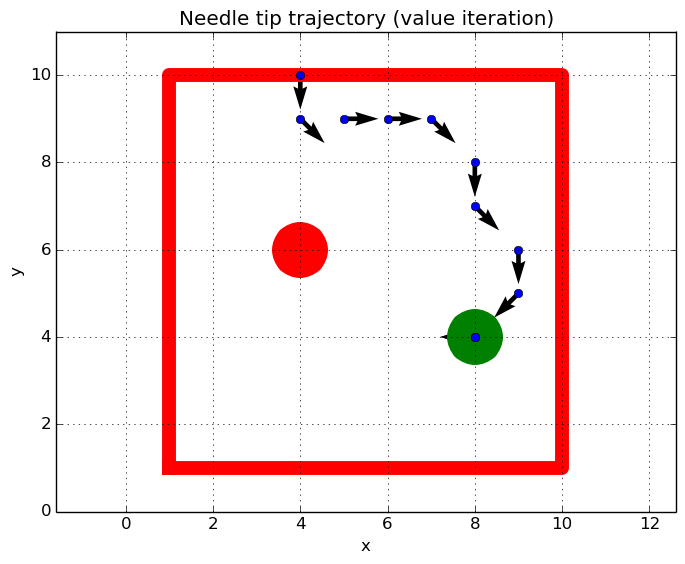

Target reached


In [54]:
s = NeedleState(4,10,7)
hist_vi = HistoryRecorder()

r = simulate(hist_vi, mdp, policy_vi, s)

println("Total discounted reward: $r")

if hist_MCTS.state_hist[end].x == mdp.reward_states[1].x && hist_MCTS.state_hist[end].y == mdp.reward_states[1].y
    println("Target reached")
else
    println("Target missed")
end

# define tissue environment
plot([1 10 10 1 1]',[1 1 10 10 1]',linewidth=10,color="r") # tissue bounds
plot(mdp.reward_states[1].x,mdp.reward_states[1].y,marker="o",markersize=40,color="g",markeredgecolor="none")
plot(mdp.reward_states[9].x,mdp.reward_states[9].y,marker="o",markersize=40,color="r",markeredgecolor="none")
hold(true)

for state in hist_vi.state_hist
    plot(state.x,state.y,color="b",marker="o")
    quiver(state.x,state.y,0.5*cos((state.psi-1)*pi/4),0.5*sin((state.psi-1)*pi/4))
end

title("Needle tip trajectory (value iteration)")
axis("equal")
axis([0, 11, 0, 11])
xlabel("x")
ylabel("y")
grid(true)

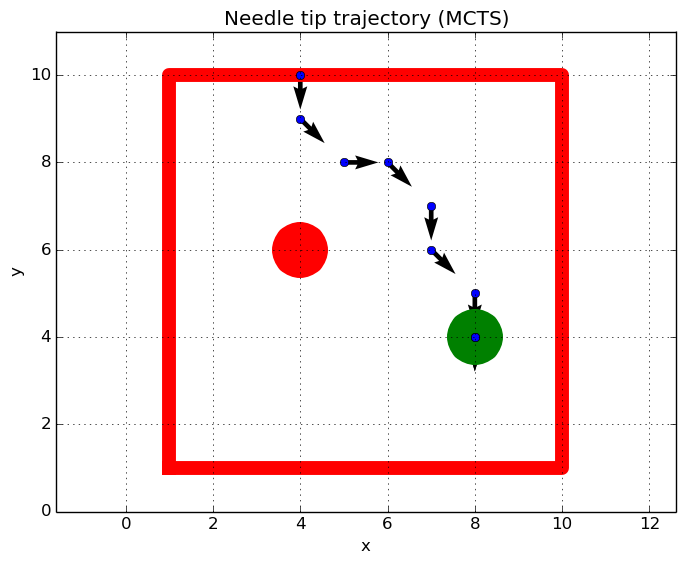

Total discounted reward: 42.13436210000001
Target reached


In [55]:
s = NeedleState(4,10,7)

hist_MCTS = HistoryRecorder()
r = simulate(hist_MCTS, mdp, policy_MCTS, s)

println("Total discounted reward: $r")

if hist_MCTS.state_hist[end].x == mdp.reward_states[1].x && hist_MCTS.state_hist[end].y == mdp.reward_states[1].y
    println("Target reached")
else
    println("Target missed")
end

# define tissue environment
plot([1 10 10 1 1]',[1 1 10 10 1]',linewidth=10,color="r") # tissue bounds
plot(mdp.reward_states[1].x,mdp.reward_states[1].y,marker="o",markersize=40,color="g",markeredgecolor="none")
plot(mdp.reward_states[9].x,mdp.reward_states[9].y,marker="o",markersize=40,color="r",markeredgecolor="none")
hold(true)

for state in hist_MCTS.state_hist
    plot(state.x,state.y,color="b",marker="o")
    quiver(state.x,state.y,0.5*cos((state.psi-1)*pi/4),0.5*sin((state.psi-1)*pi/4))
end

title("Needle tip trajectory (MCTS)")
axis("equal")
axis([0, 11, 0, 11])
xlabel("x")
ylabel("y")
grid(true)

In [29]:
# N = 100000
# r_all = ones(1,N)
# for i = 1:N
#     r_all[i] = simulate(hist_vi, mdp, policy_vi, s)
# end
# println(value(policy_vi, s))
# mean(r_all)